**Clone the repository**

In [ ]:
! git clone https://github.com/pabloac31/ML-workshop.git
%cd ML-workshop

Cloning into 'ML-workshop'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 41 (delta 5), reused 17 (delta 3), pack-reused 22
Unpacking objects: 100% (41/41), done.
/content/ML-workshop


**Using Tensorflow v1**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [ ]:
from cifar10_models import *
from adversarial_attacks import *
import torchvision.models as models
import json

**Use CUDA if available**

In [ ]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


### Experiments with CIFAR10 pretrained models.

**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [ ]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)   # Used to test the models
adv_loader = testloader_cifar10('./data', batch_size=1)                     # Used for adversarial attacks

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Load InceptionV3 model pretrained on CIFAR10**

In [ ]:
iv3 = inception_v3(pretrained=True)

**Test model**

In [ ]:
acc = test_model(iv3, device, test_loader)
print('\nAccuracy on the CIFAR10 test set:', acc)

100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


Accuracy on the CIFAR10 test set: 0.9541


**Set method parameters**

In [ ]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.01, 'max_iter': 50, 'p': 2, 'clip': True}

**Testing a method on a random CIFAR10 image**

Using FGSM...


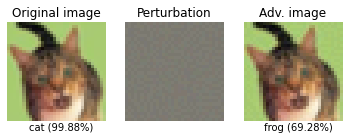


Using DeepFool...


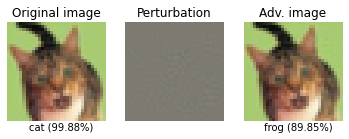

Number of iterations needed:  1


In [ ]:
image, label = next(iter(adv_loader))
print("Using FGSM...")
_,_ = test_method(iv3, device, image.clone(), label.clone(), method='fgsm', params=params_fgsm)
print("\nUsing DeepFool...")
_,_ = test_method(iv3, device, image.clone(), label.clone(), method='deepfool', params=params_deepfool)

**Perform a complete attack and show the results**

In [ ]:
print("Using FGSM...")
attack_model(iv3, device, adv_loader, 'fgsm', params_fgsm)
print("\nUsing DeepFool...")
attack_model(iv3, device, adv_loader, 'deepfool', params_deepfool)

  0%|          | 1/10000 [00:00<19:04,  8.73it/s]

Using FGSM...


  0%|          | 0/10000 [00:00<?, ?it/s]


======== RESULTS ========
Test Accuracy = 5575 / 10000 = 0.5575
Average time = 0.0226

Using DeepFool...


100%|██████████| 10000/10000 [1:29:23<00:00,  1.86it/s]


======== RESULTS ========
Test Accuracy = 767 / 10000 = 0.0767
Average time = 0.4978
Avg. iters = 2.22


In [ ]:
params_fgsm_2 = {'epsilon': 0.1, 'clip': True}
attack_model(iv3, device, adv_loader, 'fgsm', params_fgsm_2)

100%|██████████| 10000/10000 [12:03<00:00, 13.82it/s]


======== RESULTS ========
Test Accuracy = 2827 / 10000 = 0.2827
Average time = 0.0232


### Experiments using Imagenet pretrained models

**Get the names of ImageNet classes**

In [ ]:
with open('imagenet_class_index.json') as f:
  class_idx = json.load(f)

**Load InceptionV3 model**
pretrained on ImageNet

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


**Load and image from its url**

In [ ]:
img = torch.unsqueeze(image_loader('https://wi-images.condecdn.net/image/pA6zNA3kvoG/crop/810/f/gettyimages-881725440.jpg'), dim=0)
img = img.to(device)

**Use the previous model to classify the image**

In [ ]:
model.eval()
model = model.to(device)
img.requires_grad = True

output = model(img)
pred = output.max(1, keepdim=True)[1]
print('Input image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Input image classified as street_sign with a 99.98% confidence


**Show the image with its label and confidence**

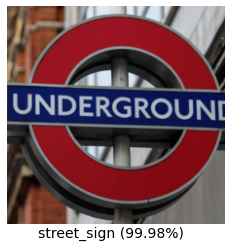

In [ ]:
f = plt.figure()
plt.axis('off')
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)
plt.imshow(displayable(img.clone().detach().cpu(), dataset='imagenet'))

**Compute an adversarial image.**
Select the method you want to use

In [ ]:
t0= time.clock()

## FGSM
#adv_x, _ = fgsm(model, img, pred[0], output, epsilon=0.01, clip=False, dataset='imagenet')

## DeepFool 
_, adv_x, _, n_iter = deepfool(model, device, img, num_classes=100, lambda_fac=1.02, p=2, dataset='imagenet')

t1 = time.clock() - t0
print("Time elapsed: {:.2f} seconds".format(t1)) # CPU seconds elapsed 

Time elapsed: 4.77 seconds


**Classify the adversarial image**

In [ ]:
output = model(adv_x)
pred = output.max(1, keepdim=True)[1]
print('Adversarial image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Adversarial image classified as cash_machine with a 51.75% confidence


**Show the adversarial image with its label and confidence**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.08, 'cash_machine (51.75%)')

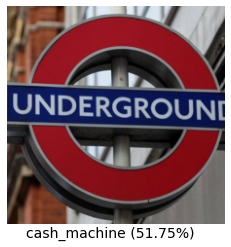

In [ ]:
f = plt.figure()
plt.axis('off')
plt.imshow(displayable(adv_x.clone().detach().cpu(), dataset='imagenet'))
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)